## Approach 2: Using part of the data
### Intuition:
In this aaproach I'll use data starting from 10th month according to 'ts_month' feature.

In [3]:
pip install git+https://github.com/modelplot/modelplotpy.git

  Cloning https://github.com/modelplot/modelplotpy.git to /tmp/pip-req-build-n7_ekr0u
  Running command git clone --filter=blob:none --quiet https://github.com/modelplot/modelplotpy.git /tmp/pip-req-build-n7_ekr0u
  Resolved https://github.com/modelplot/modelplotpy.git to commit 83ca84e67c357ee3bd98e296b94219c1a0863f68
  Preparing metadata (setup.py) ... done
  Created wheel for modelplotpy: filename=modelplotpy-1.0.0-py2.py3-none-any.whl size=36250 sha256=cbfa9949ddd1f04a68e72351e541bdbcb34cc6f2b535338235b7a140eae6b4e1
  Stored in directory: /tmp/pip-ephem-wheel-cache-1x99nlr7/wheels/bd/c9/e9/9fd5236a7377d81a5689c597f279013d333551519fdfdf85d4
Successfully built modelplotpy
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import logging
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
import optuna
import shap
import modelplotpy as mp
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

In [7]:
def read_data(path: str, files: list, separator=','):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file, sep=separator))
    return dataframes


path = '/kaggle/input/bank-marketing-uci/'
files = ['bank_data.csv']
bank_data = read_data(path, files)[0]
bank_data = bank_data[bank_data.ts_month >= 10]
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
36214,60,admin.,married,university.degree,0,1,0,cellular,jun,mon,...,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1,10
36215,29,admin.,single,high.school,0,1,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,1,10
36216,32,technician,married,professional.course,0,1,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10
36217,45,unemployed,married,basic.9y,0,1,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10
36218,35,blue-collar,single,professional.course,0,0,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10


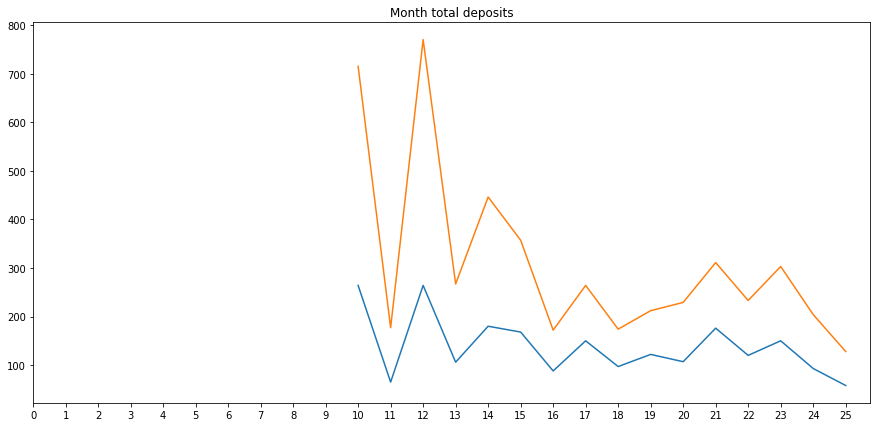

In [8]:
fig = plt.figure(figsize=(15, 7))
plt.plot(bank_data.groupby(['ts_month'])['y'].sum())
plt.plot(bank_data.groupby(['ts_month'])['y'].count())
plt.xticks(np.arange(26))
plt.title('Month total deposits')
plt.show()

In [9]:
bank_data = bank_data.drop('duration', axis=1)

In [10]:
def make_bins(data, feature, label_names, cut_points):
    data[feature] = pd.cut(data[feature], cut_points, labels=label_names)


age_labels = [1, 2, 3, 4]
age_cut_pts = [16, 25, 35, 64, 98]
make_bins(bank_data, 'age', age_labels, age_cut_pts)
bank_data['age'] = bank_data['age'].astype('int8')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
36214,3,admin.,married,university.degree,0,1,0,cellular,jun,mon,...,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1,10
36215,2,admin.,single,high.school,0,1,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,1,10
36216,2,technician,married,professional.course,0,1,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10
36217,3,unemployed,married,basic.9y,0,1,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10
36218,2,blue-collar,single,professional.course,0,0,0,cellular,jun,mon,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10


In [11]:
def encode_consecutive(data, feature, encoding):
    data[feature] = data[feature].map(encoding)
    

encode_consecutive(bank_data, 'day_of_week', {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})
encode_consecutive(bank_data, 'month', {'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12,
                                        'mar': 3, 'apr': 4})
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
36214,3,admin.,married,university.degree,0,1,0,cellular,6,1,...,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1,10
36215,2,admin.,single,high.school,0,1,0,cellular,6,1,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,1,10
36216,2,technician,married,professional.course,0,1,0,cellular,6,1,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10
36217,3,unemployed,married,basic.9y,0,1,0,cellular,6,1,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10
36218,2,blue-collar,single,professional.course,0,0,0,cellular,6,1,...,999,0,nonexistent,-2.9,92.963,-40.8,1.266,5076.2,0,10


In [12]:
def encode_pdays(data):
    data.loc[data.pdays < 999, 'pdays'] = 1
    data.loc[data.pdays == 999, 'pdays'] = 0
    
    
encode_pdays(bank_data)

In [13]:
def encode_previous(data):
    data.loc[data.previous > 1, 'previous'] = 2
    
    
encode_previous(bank_data)

In [14]:
def encode_campaign(data):
    #data.loc[(data.campaign >= 3) & (data.campaign <= 4), 'campaign'] = 3.5
    data.loc[data.campaign >= 8, 'campaign'] = 8
    
    
encode_campaign(bank_data)

In [15]:
def encode_categorical(features, data):
    for feature in features:
        data = pd.concat([data.drop(feature, axis=1), pd.get_dummies(data[feature], prefix=feature, prefix_sep='_',
                                                                     drop_first=True, dummy_na=False)], axis=1)
    return data
        
cat_features = ['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan']
bank_data = encode_categorical(cat_features, bank_data)

In [16]:
bank_data.sample(10)

,age,month,day_of_week,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,education_university.degree,education_unknown,contact_telephone,poutcome_nonexistent,poutcome_success,default_unknown,housing_1,housing_unknown,loan_1,loan_unknown
38429,2,10,4,1,0,1,-3.4,92.431,-26.9,0.733,...,1,0,0,0,0,0,0,0,1,0
38772,3,11,4,1,0,1,-3.4,92.649,-30.1,0.714,...,0,0,0,0,0,0,0,0,0,0
39531,2,4,4,6,0,0,-1.8,93.749,-34.6,0.659,...,1,0,0,1,0,0,0,0,0,0
37515,3,8,4,2,0,1,-2.9,92.201,-31.4,0.873,...,0,0,0,0,0,0,1,0,0,0
36512,1,6,3,2,0,1,-2.9,92.963,-40.8,1.260,...,0,0,0,0,0,0,1,0,1,0
37377,3,8,3,2,1,1,-2.9,92.201,-31.4,0.879,...,0,1,0,0,1,0,1,0,0,0
37666,2,8,3,2,0,0,-2.9,92.201,-31.4,0.854,...,0,0,1,1,0,0,1,0,0,0
37504,1,8,4,1,0,0,-2.9,92.201,-31.4,0.873,...,1,0,0,1,0,0,0,0,1,0
38724,3,11,3,2,0,2,-3.4,92.649,-30.1,0.715,...,0,0,0,0,0,0,0,0,0,0
37997,3,9,2,2,1,1,-3.4,92.379,-29.8,0.788,...,0,0,0,0,1,0,0,0,0,0


0.9501284379865075
0.6851271952479339
0.8280346820809249
0.5506993006993007
0.8660664040517726
0.6349431818181818
0.761968085106383
0.4474431818181818
0.9066455696202531
0.7159090909090909


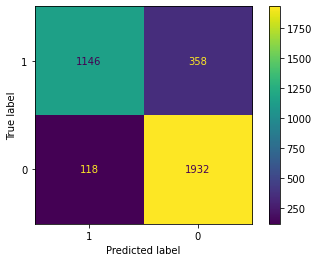

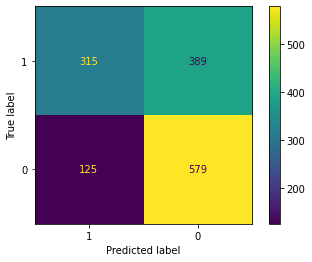

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
y = bank_data.y
X = bank_data.drop('y', axis = 1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, y_train = bank_data[bank_data.ts_month < 20].drop(columns='y'), bank_data[bank_data.ts_month < 20].y
X_test, y_test = bank_data[bank_data.ts_month >= 20].drop(columns='y'), bank_data[bank_data.ts_month >= 20].y

model = xgb.XGBClassifier()
model.set_params(**{'random_state': 0,
                    'n_estimators': 77,
                     'max_depth': 27,
                     'reg_alpha': 0.289236345672789,
                     'reg_lambda': 0.5701328004075146,
                     'min_child_weight': 2,
                     'gamma': 1.8010244651973957,
                     'learning_rate': 0.1216900720131488,
                     'colsample_bytree': 0.840084348216454,
                     'subsample': 0.8190260428355959})

model.fit(X_train, y_train)
print(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print(f1_score(y_train, model.predict(X_train)))
print(f1_score(y_test, model.predict(X_test)))
print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))
print(recall_score(y_train, model.predict(X_train)))
print(recall_score(y_test, model.predict(X_test)))
print(precision_score(y_train, model.predict(X_train)))
print(precision_score(y_test, model.predict(X_test)))

cm = confusion_matrix(y_train, model.predict(X_train), labels = [1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()
cm = confusion_matrix(y_test, model.predict(X_test), labels = [1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()

Default scope value no_comparison selected, single evaluation line will be plotted.
The label with smallest class is 1
Target class 1, dataset test data and model xgb.


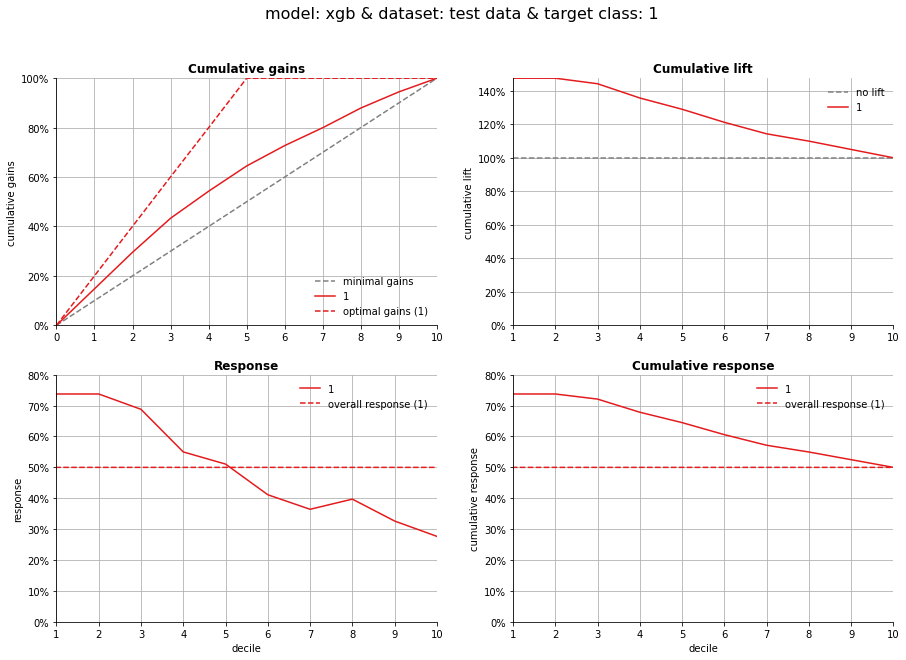

<AxesSubplot:title={'center':'Cumulative gains'}, ylabel='cumulative gains'>

In [20]:
obj = mp.modelplotpy(feature_data = [X_train, X_test]
                     , label_data = [y_train, y_test]
                     , dataset_labels = ['train data', 'test data']
                     , models = [model]
                     , model_labels = ['xgb']
                     )

ps = obj.plotting_scope(select_model_label = ['xgb'], select_dataset_label = ['test data'])

mp.plot_all(ps, save_fig = False)

### Model Selection & HPO

Train/valid/test split: I'll split data according to 'ts_month' feature:
* Train: 10 - 19 months
* Valid: 20-22 month
* Test: 23-25 month

Train data, used for cross validation will be splited in k + 1 equal folds so as to perform k iterations of cross validation. Such split is chosed due to inequality of number of data samples in each 'ts_month'.

In [21]:
def bank_metric(y_valid, y_pred, normalize=True):
    coeffs = np.array([5, -1.5, -0.25, 0.25])
    cm = confusion_matrix(y_valid, y_pred, labels = [1,0])
    cm = np.reshape(cm, 4)
    if normalize:
        return np.dot(cm, coeffs) / (sum(y_valid) * coeffs[0] + (len(y_valid) - sum(y_valid)) * coeffs[3])
    else:
        return np.dot(cm, coeffs)


def cumgain_auc_score(y_valid, y_pred, normalize=True):
    def calculate_area(y):
        percentiles = np.array_split(y, 100)
        area = 0
        first = 0
        second = 0
        total = sum(y)
        for p in percentiles:
            second += sum(p) / total
            area += (first + second) * 0.5 * 0.01
            first = second
        return area
    
    y_valid = list(y_valid)
    model = [x[1] for x in sorted(zip(y_pred, y_valid), key=lambda x: x[0], reverse=True)]
    wizard = sorted(y_valid, reverse=True)
    if normalize:
        return calculate_area(model) / calculate_area(wizard)
    else:
        return calculate_area(model)

In [52]:
class TimeSeriesCycle:
    def __init__(self,
                 data: pd.DataFrame,
                 models_with_params: dict,
                 evaluation_metric: object,
                 loss_function: object,
                 train_border: int,
                 valid_border: int,
                 test_border: int,
                 k: int,
                 models_folder: str,
                 studies_folder: str,
                 predict_proba: bool,
                 sampling: bool
                ):
        self.data = data
        self.models_with_params = models_with_params
        self.evaluation_metric = evaluation_metric
        self.loss_function = loss_function
        self.train_border = train_border
        self.valid_border = valid_border
        self.test_border = test_border
        self.k = k
        self.best_estimators = []
        self.fitted_best_estimators = []
        self.final_estimator = None
        self.fitted_final_estimator = None
        self.shap_values = None
        self.models_folder = models_folder
        self.studies_folder = studies_folder
        self.predict_proba = predict_proba
        self.sampling = sampling
        
        
    def resample(self, X, y, strategy=None, over_strategy=None, under_strategy=None, random=True):
        if self.sampling:
            if random:
                over = SMOTE(sampling_strategy=over_strategy, random_state=0)
                under = RandomUnderSampler(sampling_strategy=under_strategy, random_state=0)
                X, y = over.fit_resample(X, y)
                X, y = under.fit_resample(X, y)
            else:
                #sm = SMOTEENN(sampling_strategy=0.8, random_state=0)
                sm = SMOTETomek(sampling_strategy=strategy, random_state=0)
                X, y = sm.fit_resample(X, y)
        print(y.value_counts())
        return X, y
    
    
    def make_pipeline(self, model, params, scaler):      
        scalers = {'MinMax': MinMaxScaler(), 'Standard': StandardScaler(), 'Robust': RobustScaler()}
        pipeline = Pipeline(steps=[('scaler', scalers.get(scaler, None)), ('model', model)])
        return pipeline
    
        
    def hpo(self):
        def evaluate_model(self, model, params, n_trials, cv_dataframes):
            def objective(trial):
                if type(model).__name__ in {'KNeighborsClassifier', 'LogisticRegression'}:
                    scaler = trial.suggest_categorical('scaler', ['MinMax', 'Standard', 'Robust'])
                else:
                    scaler = None
                    
                model.set_params(**params(trial))
                pipeline = self.make_pipeline(model, params, scaler)

                train_scores = []
                valid_scores = []
                
                for X_train, y_train, X_valid, y_valid in cv_dataframes:
                    pipeline.fit(X_train, y_train)
                    if self.predict_proba:
                        train_scores.append(self.loss_function(y_train, pipeline.predict_proba(X_train)[:,1]))
                        valid_scores.append(self.loss_function(y_valid, pipeline.predict_proba(X_valid)[:,1]))
                    else:
                        train_scores.append(self.loss_function(y_train, pipeline.predict(X_train)))
                        valid_scores.append(self.loss_function(y_valid, pipeline.predict(X_valid)))
                    
                print('Train scores:', train_scores)
                print('Mean train score:', np.mean(train_scores))
                print('Valid scores:', valid_scores)
                return np.mean(valid_scores)

            
            print('Hyperparameters tuning for', type(model).__name__) 
            start = time.time()
            #optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler(sys.stdout))
            study_name = str(type(model).__name__) + '-study'
            #storage_name = self.studies_folder + 'sqlite:///{}.db'.format(study_name)
            #study = optuna.create_study(study_name=study_name, storage=storage_name, direction='maximize',
            #                            sampler=optuna.samplers.TPESampler(seed=0), load_if_exists=True)
            study = optuna.create_study(study_name=study_name, direction='maximize', sampler=optuna.samplers.TPESampler(seed=0))
            study.optimize(objective, n_trials=n_trials, show_progress_bar=True,
                           gc_after_trial=True)
            end = time.time()

            print('Best score: {}'.format(study.best_value))
            print('Best params: {}'.format(study.best_params))
            print('Taken time: {}'.format(int(end - start)))

            self.best_estimators.append((model, study.best_params))
            #json_txt = json.dumps(study.best_params, indent=4)
            #with open(self.models_folder + str(type(model).__name__) + '.txt', "w") as file: 
            #    file.write(json_txt)
            print('Tuning completed for {}!'.format(type(model).__name__))

        
        print('Preparing datasets for cross validation...')
        cv_dataframes = []
        fold_len = len(self.data[self.data.ts_month < self.train_border + 1]) // (self.k + 1)
        for i in range(1, self.k + 1):
            X_train = self.data.iloc[:fold_len * i].drop(columns=['y'])
            y_train = self.data.iloc[:fold_len * i]['y']
            X_valid = self.data.iloc[fold_len * i: fold_len * (i + 1)].drop(columns=['y'])
            y_valid = self.data.iloc[fold_len * i: fold_len * (i + 1)]['y']

            X_train, y_train = self.resample(X_train, y_train, over_strategy=0.7, under_strategy=0.9)
            X_valid, y_valid = self.resample(X_valid, y_valid, over_strategy=0.5, under_strategy=0.9) #strategy=0.9, random=False)
            cv_dataframes.append((X_train, y_train, X_valid, y_valid))
            
        for model, (params, n_trials) in self.models_with_params.items():
            evaluate_model(self, model, params, n_trials, cv_dataframes)
        print('Tuning completed for all models!')
     
    
    def compare_models(self):
        X_train = self.data[self.data['ts_month'] <= self.train_border].drop(columns=['y'])
        y_train = self.data[self.data['ts_month'] <= self.train_border]['y']
        X_valid = self.data[(self.data['ts_month'] > self.train_border) &
                            (self.data['ts_month'] <= self.valid_border)].drop(columns=['y'])
        y_valid = self.data[(self.data['ts_month'] > self.train_border) &
                            (self.data['ts_month'] <= self.valid_border)]['y']
        
        X_train, y_train = self.resample(X_train, y_train, over_strategy=0.7, under_strategy=0.9)
        
        valid_scores = []
        for model, params in self.best_estimators:
            scaler = params.pop('scaler', None)
            model.set_params(**params)
            pipeline = self.make_pipeline(model, params, scaler) 
            
            pipeline.fit(X_train, y_train)
            
            train_score = self.evaluation_metric(y_train, pipeline.predict_proba(X_train)[:,1])
            valid_score = self.evaluation_metric(y_valid, pipeline.predict_proba(X_valid)[:,1])            

            print('Train score for {} ='.format(type(model).__name__), train_score)
            print('Validation score for {} = '.format(type(model).__name__), valid_score)
            valid_scores.append(valid_score)
            
            self.fitted_best_estimators.append(model)

        obj = mp.modelplotpy(feature_data = [X_train, X_valid],
                             label_data = [y_train, y_valid],
                             dataset_labels = ['train data', 'valid data'],
                             models = self.fitted_best_estimators,
                             model_labels = [type(model).__name__ for model in self.fitted_best_estimators]
                             )
        ps = obj.plotting_scope(scope = 'compare_models', select_dataset_label = ['train data'])
        mp.plot_all(ps, save_fig = False)
        plt.show()
        
        ps = obj.plotting_scope(scope = 'compare_models', select_dataset_label = ['valid data'])
        mp.plot_all(ps, save_fig = False)
        plt.show()

        self.final_estimator = self.best_estimators[np.argmax(valid_scores)]
    
    
    def get_predictions(self):
        start = time.time()
        
        model, params = self.final_estimator
        scaler = params.pop('scaler', None)
        model.set_params(**params)
        pipeline = self.make_pipeline(model, params, scaler)
        print('Final model: ' + str(model))
        
        X = self.data[self.data['ts_month'] <= self.valid_border].drop(columns=['y'])
        y = self.data[self.data['ts_month'] <= self.valid_border]['y']
        X, y = self.resample(X, y, over_strategy=0.7, under_strategy=0.9)
        
        print('Fitting...')
        pipeline.fit(X, y)
        X_test = self.data[(self.data['ts_month'] > self.valid_border) &
                           (self.data['ts_month'] <= self.test_border)].drop(columns=['y'])
        y_test = self.data[(self.data['ts_month'] > self.valid_border) &
                           (self.data['ts_month'] <= self.test_border)]['y']
        print('Test score for {} ='.format(type(model).__name__),
              self.evaluation_metric(y_test, pipeline.predict_proba(X_test)[:,1]))
        
        cm = confusion_matrix(y_test, pipeline.predict(X_test), labels = [1, 0])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
        disp.plot()
        
        end = time.time()
        print('Took ' + str(int(end - start)) + ' seconds to get final predictions')
        self.fitted_final_estimator = model
    
    
    def explain_model(self, model, data='train'):
        explainer = shap.Explainer(model)
        if data == 'train':
            X = self.data[self.data['ts_month'] <= self.valid_border].sample(1000,random_state=0).drop(columns=['y'])
        else:
            X = self.data[self.data['ts_month'] == self.test_border].drop(columns=['y'])
        self.shap_values = explainer(X)
        shap.summary_plot(self.shap_values, X)

In [56]:
xgb_model = xgb.XGBClassifier()
def xgb_params(trial):
    params = {
        'random_state': 0,
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 4),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'gamma': trial.suggest_float('gamma', 0, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'subsample': trial.suggest_float('subsample', 0.4, 0.9),
        'nthread': -1
    }
    return params

rf_model = RandomForestClassifier()
def rf_params(trial):
    params = {
        'random_state': 0,
        'bootstrap': trial.suggest_categorical('bootstrap', ['True', 'False']),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'n_jobs': -1
    }
    return params

log_reg_model = LogisticRegression()
def log_reg_params(trial):
    params = {
        'random_state': 0,
        'tol' : trial.suggest_float('tol', 1e-6 , 1e-3),
        'C' : trial.suggest_float('C', 1e-7, 10.0, log=True),
        'fit_intercept' : trial.suggest_categorical('fit_intercept', [True, False]),
        'solver' : trial.suggest_categorical('solver', ['lbfgs', 'liblinear']),
        'max_iter': 1000,
        'n_jobs' : -1
    }
    return params
    
knn_model = KNeighborsClassifier()
def knn_params(trial):
    params = {
        'n_neighbors': trial.suggest_int("n_neighbors", 1, 30),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        'n_jobs' : -1
    }
    return params


tsc = TimeSeriesCycle(data=bank_data,
                      models_with_params={
                            log_reg_model: (log_reg_params, 1000),
                            #knn_model: (knn_params, 1),
                            xgb_model: (xgb_params, 10),
                            rf_model: (rf_params, 10)
                      },
                      evaluation_metric=cumgain_auc_score,
                      loss_function=f1_score,
                      train_border=19,
                      valid_border=22,
                      test_border=25,
                      k = 5,
                      models_folder='',
                      studies_folder='',
                      predict_proba=False,
                      sampling=False
                     )

In [57]:
tsc.hpo()

[I 2022-12-11 19:55:45,909] A new study created in memory with name: LogisticRegression-study


Preparing datasets for cross validation...
0    364
1    228
Name: y, dtype: int64
0    388
1    204
Name: y, dtype: int64
0    752
1    432
Name: y, dtype: int64
0    391
1    201
Name: y, dtype: int64
0    1143
1     633
Name: y, dtype: int64
0    351
1    241
Name: y, dtype: int64
0    1494
1     874
Name: y, dtype: int64
1    298
0    294
Name: y, dtype: int64
0    1788
1    1172
Name: y, dtype: int64
1    332
0    260
Name: y, dtype: int64
Hyperparameters tuning for LogisticRegression


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/1000 [00:00<?, ?it/s]

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.36253776435045315, 0.3074324324324324, 0.3439911797133407, 0.35930047694753575, 0.4364820846905538]
Mean train score: 0.36194878762686317
Valid scores: [0.12931034482758622, 0.4050632911392405, 0.41618497109826585, 0.525, 0.6899766899766901]
[I 2022-12-11 19:55:46,046] Trial 0 finished with value: 0.4331070594083566 and parameters: {'scaler': 'Standard', 'tol': 0.0005453382998139001, 'C': 0.00024504079607416023, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 0 with value: 0.4331070594083566.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.574108818011257, 0.45228758169934635, 0.5214285714285714, 0.5069949636261892, 0.5161870503597122]
Mean train score: 0.5142013970250152
Valid scores: [0.5026595744680852, 0.4012158054711246, 0.4644549763033175, 0.49676025917926564, 0.7186147186147186]
[I 2022-12-11 19:55:46,503] Trial 1 finished with value: 0.5167410668073023 and parameters: {'scaler': 'Standard', 'tol': 0.0005684765165328385, 'C': 2.5396455415115335, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.
Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.0, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:55:48,299] Trial 2 finished with value: 0.0 and parameters: {'scaler': 'Robust', 'tol': 0.000799359405652507, 'C': 0.0004918525168182288, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.2671232876712329, 0.25992779783393505, 0.2982248520710059, 0.3391521197007481, 0.41231126596980255]
Mean train score: 0.3153478646493449
Valid scores: [0.5046728971962616, 0.30824372759856633, 0.32807570977917977, 0.4636363636363637, 0.7152317880794702]
[I 2022-12-11 19:55:48,650] Trial 3 finished with value: 0.4639720972579683 and parameters: {'scaler': 'MinMax', 'tol': 0.0002652910564925224, 'C': 0.156267806278179, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0, 0.0, 0.015455950540958267, 0.015783540022547914, 0.07507987220447285]
Mean train score: 0.021263872553595804
Valid scores: [0.5042016806722689, 0.0, 0.0, 0.01986754966887417, 0.2822384428223844]
[I 2022-12-11 19:55:48,999] Trial 4 finished with value: 0.16126153463270548 and parameters: {'scaler': 'Robust', 'tol': 0.00068213847880438, 'C': 7.517322886250542e-05, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.
Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.0, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:55:49,342] Trial 5 finished with value: 0.0 and parameters: {'scaler': 'MinMax', 'tol': 0.0003161129225732597, 'C': 8.122433559209665e-05, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0, 0.0, 0.0, 0.0, 0.057236304170073596]
Mean train score: 0.01144726083401472
Valid scores: [0.4956772334293949, 0.0, 0.0, 0.0, 0.44725738396624476]
[I 2022-12-11 19:55:49,688] Trial 6 finished with value: 0.18858692347912792 and parameters: {'scaler': 'Robust', 'tol': 0.00025403831093724237, 'C': 0.0005376333279584158, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.
Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.0, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:55:50,088] Trial 7 finished with value: 0.0 and parameters: {'scaler': 'Robust', 'tol': 0.0008211722366180873, 'C': 5.981501367285096e-07, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.34936708860759497, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:55:50,390] Trial 8 finished with value: 0.06987341772151899 and parameters: {'scaler': 'MinMax', 'tol': 4.0148604462066354e-05, 'C': 1.830019429113411e-05, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.4935437589670014, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:55:50,736] Trial 9 finished with value: 0.09870875179340029 and parameters: {'scaler': 'Robust', 'tol': 0.0005670348527523686, 'C': 1.327748830368411e-05, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5730337078651685, 0.40896358543417366, 0.5221112696148359, 0.5075461151481274, 0.5164192532613585]
Mean train score: 0.5056147862647328
Valid scores: [0.5026595744680852, 0.3836477987421384, 0.46335697399527187, 0.49676025917926564, 0.7186147186147186]
[I 2022-12-11 19:55:51,200] Trial 10 finished with value: 0.5130078649998959 and parameters: {'scaler': 'Standard', 'tol': 0.0009640124239142082, 'C': 4.190116392232642, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5730337078651685, 0.3904619970193741, 0.5221112696148359, 0.5083798882681564, 0.5161870503597122]
Mean train score: 0.5020347826254494
Valid scores: [0.5026595744680852, 0.36482084690553745, 0.46226415094339623, 0.49783549783549785, 0.7186147186147186]
[I 2022-12-11 19:55:51,672] Trial 11 finished with value: 0.5092389577534471 and parameters: {'scaler': 'Standard', 'tol': 0.0009267852421735382, 'C': 7.599931358973192, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 1 with value: 0.5167410668073023.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5263157894736842, 0.5183585313174945, 0.5031091011871114, 0.5209090909090909]
Mean train score: 0.5260724684218785
Valid scores: [0.5019815059445177, 0.4916467780429594, 0.4488778054862843, 0.5741088180112571, 0.7186147186147186]
[I 2022-12-11 19:55:52,072] Trial 12 finished with value: 0.5470459252199474 and parameters: {'scaler': 'Standard', 'tol': 0.0009790081495119228, 'C': 0.09030724729500872, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 12 with value: 0.5470459252199474.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5632183908045977, 0.5252100840336135, 0.5144927536231886, 0.49655963302752293, 0.5182815356489945]
Mean train score: 0.5235524794275834
Valid scores: [0.5046728971962617, 0.48815165876777256, 0.45454545454545453, 0.5890652557319225, 0.7186147186147186]
[I 2022-12-11 19:55:52,469] Trial 13 finished with value: 0.5510099969712259 and parameters: {'scaler': 'Standard', 'tol': 0.00041245868803733163, 'C': 0.03407133539346071, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5531914893617021, 0.5159914712153518, 0.5096296296296295, 0.494131455399061, 0.5138376383763836]
Mean train score: 0.5173563367964256
Valid scores: [0.4861111111111111, 0.4811320754716981, 0.43342036553524804, 0.5982905982905982, 0.7186147186147186]
[I 2022-12-11 19:55:52,831] Trial 14 finished with value: 0.5435137738046748 and parameters: {'scaler': 'Standard', 'tol': 0.00038387816444884423, 'C': 0.013140172318230526, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.5561904761904761, 0.5221052631578947, 0.5091709464416728, 0.4944991314418066, 0.5172255397335783]
Mean train score: 0.5198382713930856
Valid scores: [0.49864498644986444, 0.4929577464788732, 0.4322916666666667, 0.5958904109589042, 0.7186147186147186]
[I 2022-12-11 19:55:53,219] Trial 15 finished with value: 0.5476799058338054 and parameters: {'scaler': 'Standard', 'tol': 0.00010940056558523344, 'C': 0.019016174566726933, 'fit_intercept': Fal

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.37837837837837845, 0.3079584775086505, 0.2997658079625293, 0.33665008291873966, 0.42111302352266206]
Mean train score: 0.348773154058192
Valid scores: [0.5006993006993006, 0.3, 0.3116883116883117, 0.4019370460048426, 0.7164835164835164]
[I 2022-12-11 19:55:58,735] Trial 29 finished with value: 0.44616163497519423 and parameters: {'scaler': 'MinMax', 'tol': 0.0004932384712370962, 'C': 1.8178051685139887, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.5493230174081238, 0.510314875135722, 0.4958174904942966, 0.48087431693989074, 0.5139925373134329]
Mean train score: 0.5100644474582932
Valid scores: [0.46785714285714286, 0.4604316546762589, 0.4285714285714286, 0.6070826306913998, 0.7172264355362947]
[I 2022-12-11 19:55:59,098] Trial 30 finished with value: 0.536233858466505 and parameters: {'scaler': 'Standard', 'tol': 0.0004998741925923617, 'C': 0.005505274687354722, 'fit_intercept': False, 'solver': 'lbfgs

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.29605263157894735, 0.2724014336917563, 0.29917550058892817, 0.3388704318936877, 0.41681059297639605]
Mean train score: 0.32466211814594315
Valid scores: [0.504881450488145, 0.32167832167832167, 0.33644859813084116, 0.4753363228699551, 0.7185104052573932]
[I 2022-12-11 19:56:01,405] Trial 36 finished with value: 0.4713710196849313 and parameters: {'scaler': 'Robust', 'tol': 0.00023209570943060802, 'C': 0.21271056467158475, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.5352697095435685, 0.4642438452520516, 0.4588045234248788, 0.4321868916288124, 0.49233716475095785]
Mean train score: 0.47656842692005374
Valid scores: [0.24734982332155478, 0.4184782608695652, 0.42191780821917807, 0.5856905158069885, 0.7166123778501629]
[I 2022-12-11 19:56:01,765] Trial 37 finished with value: 0.4780097572134899 and parameters: {'scaler': 'Standard', 'tol': 0.0003009015704348911, 'C': 0.0005784428702136075, 'fit_intercept':

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.1970802919708029, 0.2379182156133829, 0.2894736842105263, 0.3397169025811823, 0.4056271981242673]
Mean train score: 0.29396325850003235
Valid scores: [0.4220183486238533, 0.2585551330798479, 0.3448275862068966, 0.4660633484162896, 0.7089467723669308]
[I 2022-12-11 19:56:02,118] Trial 38 finished with value: 0.44008223773876365 and parameters: {'scaler': 'MinMax', 'tol': 8.328845971491656e-05, 'C': 0.04837003663571653, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.0, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:56:02,513] Trial 39 finished with value: 0.0 and parameters: {'scaler': 'Robust', 'tol': 0.0007354636763365716, 'C': 0.0001592772466371429, 'fit_intercept': True, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.5510099969712259.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5633270321361058, 0.5190677966101694, 0.5219899062725306, 0.5039458850056369, 0.5176790571169537]
Mean train score: 0.5252019354282793
Valid scores: [0.5026455026455026, 0.4792176039119804, 0.4455445544554456, 0.5615384615384615, 0.7186147186147186]
[I 2022-12-11 19:56:02,922] Trial 40 finished with value: 0.5415121682332218 and parameters: {'scaler': 'Standard', 'tol': 0.0002812673641274953, 'C': 0.15628913659631083, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.5521235521235521, 0.5152173913043478, 0.49810749432248297, 0.4885954381752701, 0.5135135135135135]
Mean train score: 0.5135114778878334
Valid scores: [0.4908180300500835, 0.46411483253588515, 0.43271767810026385, 0.600337268128162, 0.7172264355362947]
[I 2022-12-11 19:56:03,286] Trial 41 finished with value: 0.5410428488701379 and parameters: {'scaler': 'Standard', 'tol': 0.0001764571532366116, 'C': 0.006202462166023943, 'fit_intercept': False

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.4935437589670014, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:56:04,917] Trial 45 finished with value: 0.09870875179340029 and parameters: {'scaler': 'Robust', 'tol': 0.00036902117375337755, 'C': 1.3478735557206704e-07, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.0, 0.0, 0.0, 0.0, 0.03347280334728034]
Mean train score: 0.006694560669456067
Valid scores: [0.3571428571428572, 0.0, 0.0, 0.0, 0.3480278422273782]
[I 2022-12-11 19:56:05,333] Trial 46 finished with value: 0.14103413987404706 and parameters: {'scaler': 'MinMax', 'tol': 0.0002449967129198037, 'C': 0.0009538160852093458, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.5510099969712259.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5633270321361058, 0.5128755364806866, 0.5248023005032351, 0.5058889512058328, 0.5171790235081375]
Mean train score: 0.5248145687667997
Valid scores: [0.50199203187251, 0.4658227848101266, 0.44334975369458124, 0.526530612244898, 0.7186147186147186]
[I 2022-12-11 19:56:05,777] Trial 47 finished with value: 0.5312619802473668 and parameters: {'scaler': 'Standard', 'tol': 0.00014532386748724842, 'C': 0.31733363110021706, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.5559845559845561, 0.5107296137339055, 0.5066864784546806, 0.4958775029446408, 0.5149976926626673]
Mean train score: 0.51685516875609
Valid scores: [0.4866385372714487, 0.47417840375586856, 0.43455497382198954, 0.598639455782313, 0.7186147186147186]
[I 2022-12-11 19:56:06,160] Trial 48 finished with value: 0.5425252178492677 and parameters: {'scaler': 'Standard', 'tol': 2.4088336288247917e-06, 'C': 0.010889607075165121, 'fit_intercept': False, '

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.40350877192982454, 0.3195876288659794, 0.3017543859649123, 0.33637116818558416, 0.42087155963302747]
Mean train score: 0.3564187029158655
Valid scores: [0.5, 0.32167832167832167, 0.32807570977917977, 0.3125, 0.7164835164835164]
[I 2022-12-11 19:56:07,068] Trial 50 finished with value: 0.4357475095882036 and parameters: {'scaler': 'Standard', 'tol': 0.00010317683824505094, 'C': 0.9010033387567614, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.5659655831739963, 0.5263157894736842, 0.5158959537572255, 0.500570125427594, 0.520510483135825]
Mean train score: 0.5258515869936651
Valid scores: [0.5033288948069242, 0.48699763593380613, 0.4584382871536524, 0.5871886120996441, 0.7186147186147186]
[I 2022-12-11 19:56:07,456] Trial 51 finished with value: 0.5509136297217491 and parameters: {'scaler': 'Standard', 'tol': 0.0002078902300124923, 'C': 0.041571071996687546, 'fit_intercept': False, 'solver': 'lbfgs'}. Best

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0, 0.0, 0.0, 0.0, 0.0]
Mean train score: 0.0
Valid scores: [0.34936708860759497, 0.0, 0.0, 0.0, 0.0]
[I 2022-12-11 19:56:10,105] Trial 58 finished with value: 0.06987341772151899 and parameters: {'scaler': 'MinMax', 'tol': 0.00023671764819918395, 'C': 4.872062877808646e-06, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.574108818011257, 0.446215139442231, 0.5224839400428266, 0.5078299776286352, 0.5161870503597122]
Mean train score: 0.5133649850969324
Valid scores: [0.5026595744680852, 0.39263803680981596, 0.46335697399527187, 0.49676025917926564, 0.7186147186147186]
[I 2022-12-11 19:56:10,544] Trial 59 finished with value: 0.5148059126134314 and parameters: {'scaler': 'Standard', 'tol': 0.0003347579046430923, 'C': 2.698169014124725, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 13 with value: 0.5510099969712259.
Train scores: [0.5633270321361058, 0.514957264957265, 0.5209235209235209, 0.5039

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.36809815950920244, 0.2946273830155979, 0.3287981859410431, 0.3496732026143791, 0.41729106628242074]
Mean train score: 0.35169759947252865
Valid scores: [0.23308270676691728, 0.3934426229508196, 0.39169139465875374, 0.5053995680345572, 0.7150715071507152]
[I 2022-12-11 19:56:14,027] Trial 68 finished with value: 0.44773755991235265 and parameters: {'scaler': 'Standard', 'tol': 0.0001713998465007732, 'C': 0.0022173986368455518, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.
Train scores: [0.5659655831739963, 0.5253164556962026, 0.5180375180375181, 0.5005688282138794, 0.5216203914428768]
Mean train score: 0.5263017553128946
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 19:56:14,415] Trial 69 finished with value: 0.5510329736106891 and parameters: {'scaler': 'Standard', 'tol': 0.000211882467108214, 'C': 0.05505949295017751, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.30163934426229505, 0.2775800711743772, 0.2977725674091442, 0.3308270676691729, 0.4244152880775813]
Mean train score: 0.32644686771851417
Valid scores: [0.502092050209205, 0.32394366197183094, 0.3096774193548387, 0.5232067510548523, 0.7175572519083969]
[I 2022-12-11 19:56:17,524] Trial 77 finished with value: 0.47529542689982474 and parameters: {'scaler': 'Robust', 'tol': 0.000254381296964918, 'C': 0.1852530821743848, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.
Train scores: [0.5659655831739963, 0.5237592397043295, 0.5176640230713772, 0.4985738733599544, 0.5218579234972677]
Mean train score: 0.525564128561385
Valid scores: [0.50199203187251, 0.491725768321513, 0.45614035087719296, 0.5899280575539567, 0.7186147186147186]
[I 2022-12-11 19:56:17,910] Trial 78 finished with value: 0.5516801854479783 and parameters: {'scaler': 'Standard', 'tol': 0.0003479814639739037, 'C': 0.05007757831301002, 'fit_intercept': False, 'solv

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5231092436974789, 0.5165945165945166, 0.4988584474885845, 0.5218579234972677]
Mean train score: 0.5252771428903689
Valid scores: [0.50199203187251, 0.491725768321513, 0.45614035087719296, 0.5857142857142857, 0.7186147186147186]
[I 2022-12-11 19:56:21,453] Trial 87 finished with value: 0.550837431080044 and parameters: {'scaler': 'Standard', 'tol': 0.0004072799706761694, 'C': 0.04815143365548096, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.
Train scores: [0.5549132947976879, 0.5180467091295117, 0.507396449704142, 0.49329446064139937, 0.5145228215767635]
Mean train score: 0.5176347471699009
Valid scores: [0.48968363136176063, 0.4894117647058823, 0.4386422976501305, 0.5972696245733788, 0.7186147186147186]
[I 2022-12-11 19:56:21,836] Trial 88 finished with value: 0.5467244073811741 and parameters: {'scaler': 'Standard', 'tol': 0.000278280551940919, 'C': 0.015169669198898422, 'fit_intercept': False, 'so

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5638095238095239, 0.5258711721224921, 0.5180375180375181, 0.5022727272727272, 0.5216203914428768]
Mean train score: 0.5263222665370276
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 19:56:25,033] Trial 96 finished with value: 0.5512660189985192 and parameters: {'scaler': 'Standard', 'tol': 0.00019794423719029816, 'C': 0.05699823115259021, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5278654048370136, 0.5205479452054795, 0.5036702428006776, 0.5204359673024523]
Mean train score: 0.526837877873527
Valid scores: [0.5026455026455026, 0.48441247002398086, 0.44776119402985076, 0.569811320754717, 0.7186147186147186]
[I 2022-12-11 19:56:25,437] Trial 97 finished with value: 0.5446490412137539 and parameters: {'scaler': 'Standard', 'tol': 0.00019951116925435915, 'C': 0.10672286116083488, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5561904761904761, 0.5231092436974789, 0.5102639296187683, 0.49537037037037035, 0.5172255397335783]
Mean train score: 0.5204319119221343
Valid scores: [0.5006765899864681, 0.4929577464788732, 0.4322916666666667, 0.5969125214408233, 0.7186147186147186]
[I 2022-12-11 19:56:25,810] Trial 98 finished with value: 0.54829064863751 and parameters: {'scaler': 'Standard', 'tol': 0.00031814603330383826, 'C': 0.01955098846554518, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.39882697947214074, 0.3119584055459272, 0.3017543859649123, 0.33884297520661155, 0.4220183486238532]
Mean train score: 0.354680218962689
Valid scores: [0.5, 0.33333333333333326, 0.33333333333333337, 0.4134615384615385, 0.7156970362239298]
[I 2022-12-11 19:56:26,237] Trial 99 finished with value: 0.459165048270427 and parameters: {'scaler': 'Standard', 'tol': 0.0002566279332610397, 'C': 0.2653660219444957, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5638095238095239, 0.5258711721224921, 0.5180375180375181, 0.5028376844494893, 0.5207100591715976]
Mean train score: 0.5262531915181242
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5854545454545454, 0.7186147186147186]
[I 2022-12-11 19:56:26,634] Trial 100 finished with value: 0.5507525723725499 and parameters: {'scaler': 'Standard', 'tol': 0.00048746638577656324, 'C': 0.05893055235196301, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5632183908045977, 0.5235602094240838, 0.5113221329437545, 0.4948216340621404, 0.5169569202566452]
Mean train score: 0.5219758574982443
Valid scores: [0.49731182795698925, 0.4941176470588235, 0.44215938303341906, 0.5961871750433275, 0.7186147186147186]
[I 2022-12-11 19:56:27,019] Trial 101 finished with value: 0.5496781503414556 and parameters: {'scaler': 'Standard', 'tol': 0.0001797676815436017, 'C': 0.02604102993904339, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.
Train scores: [0.5659655831739963, 0.5253164556962026, 0.5180375180375181, 0.5005688282138794, 0.5216203914428768]
Mean train score: 0.5263017553128946
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5884476534296029, 0.7186147186147186]
[I 2022-12-11 19:56:27,408] Trial 102 finished with value: 0.5511181485797313 and parameters: {'scaler': 'Standard', 'tol': 6.219254724282686e-05, 'C': 0.05445642946866265, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5660377358490566, 0.5247629083245521, 0.520863309352518, 0.5031091011871114, 0.5194922937443337]
Mean train score: 0.5268530696915144
Valid scores: [0.5026455026455026, 0.4867469879518072, 0.44776119402985076, 0.5654648956356736, 0.7186147186147186]
[I 2022-12-11 19:56:28,196] Trial 104 finished with value: 0.5442466597755106 and parameters: {'scaler': 'Standard', 'tol': 0.00041958090931310525, 'C': 0.11621169165691368, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.
Train scores: [0.5169491525423728, 0.45605700712589076, 0.434640522875817, 0.43588123815540114, 0.49840255591054305]
Mean train score: 0.468386095322005
Valid scores: [0.2255639097744361, 0.43010752688172044, 0.4250681198910082, 0.5828025477707006, 0.706145251396648]
[I 2022-12-11 19:56:28,556] Trial 105 finished with value: 0.47393747114290263 and parameters: {'scaler': 'Standard', 'tol': 2.426170582195125e-05, 'C': 3.7498574926390694e-05, 'fit_intercept': 

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.17843866171003717, 0.22598870056497175, 0.27845036319612587, 0.33805162364696084, 0.40586510263929626]
Mean train score: 0.2853588903514784
Valid scores: [0.41131105398457585, 0.23015873015873017, 0.33015873015873015, 0.46013667425968113, 0.6976744186046512]
[I 2022-12-11 19:56:30,051] Trial 109 finished with value: 0.4258879214332737 and parameters: {'scaler': 'MinMax', 'tol': 8.021404555276488e-05, 'C': 0.033252823122338855, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 61 with value: 0.5516801854479783.
Train scores: [0.5643939393939393, 0.5148936170212767, 0.5216138328530259, 0.5042205965109735, 0.5181159420289855]
Mean train score: 0.5246475855616402
Valid scores: [0.5026455026455026, 0.4778325123152709, 0.4455445544554456, 0.5497076023391814, 0.7186147186147186]
[I 2022-12-11 19:56:30,457] Trial 110 finished with value: 0.5388689780740238 and parameters: {'scaler': 'Standard', 'tol': 0.00013077064479052877, 'C': 0.18620648761082034, 'fit_intercept

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5253164556962026, 0.5184115523465704, 0.5011389521640092, 0.5218579234972677]
Mean train score: 0.5265380933756092
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5884476534296029, 0.7186147186147186]
[I 2022-12-11 19:56:34,067] Trial 119 finished with value: 0.5511181485797313 and parameters: {'scaler': 'Standard', 'tol': 9.403358915508012e-05, 'C': 0.052831165973074475, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5237592397043295, 0.5176640230713772, 0.5011389521640092, 0.5218579234972677]
Mean train score: 0.526077144322196
Valid scores: [0.50199203187251, 0.491725768321513, 0.45614035087719296, 0.590990990990991, 0.7186147186147186]
[I 2022-12-11 19:56:34,464] Trial 120 finished with value: 0.5518927721353851 and parameters: {'scaler': 'Standard', 'tol': 9.266954107644564e-05, 'C': 0.05149501125472051, 'fit_intercept': False, '

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5660377358490566, 0.5226554267650159, 0.5216138328530259, 0.5028248587570622, 0.5181488203266787]
Mean train score: 0.5262561349101679
Valid scores: [0.5026455026455026, 0.48910411622276034, 0.44776119402985076, 0.5638095238095239, 0.7186147186147186]
[I 2022-12-11 19:56:37,362] Trial 127 finished with value: 0.5443870110644712 and parameters: {'scaler': 'Standard', 'tol': 0.00014344270438007475, 'C': 0.12326122537316636, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5627376425855514, 0.5253164556962026, 0.5194805194805194, 0.503393665158371, 0.5202364711232378]
Mean train score: 0.5262329508087765
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4538653366583541, 0.5814814814814815, 0.7186147186147186]
[I 2022-12-11 19:56:37,749] Trial 128 finished with value: 0.5500009600837574 and parameters: {'scaler': 'Standard', 'tol': 0.00010206745089381347, 'C': 0.0745284677289732, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.28378378378378377, 0.26258992805755393, 0.2998819362455726, 0.33777038269550747, 0.41299303944315546]
Mean train score: 0.31940381404511464
Valid scores: [0.49696969696969695, 0.30824372759856633, 0.33015873015873015, 0.46013667425968113, 0.7166482910694596]
[I 2022-12-11 19:56:41,630] Trial 138 finished with value: 0.4624314240112268 and parameters: {'scaler': 'MinMax', 'tol': 0.00012330071608317885, 'C': 0.19047389045479798, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5583173996175909, 0.5174973488865324, 0.507396449704142, 0.4935972060535506, 0.5145228215767635]
Mean train score: 0.5182662451677158
Valid scores: [0.49863760217983655, 0.4894117647058823, 0.43749999999999994, 0.5948717948717949, 0.7186147186147186]
[I 2022-12-11 19:56:42,021] Trial 139 finished with value: 0.5478071760744465 and parameters: {'scaler': 'Standard', 'tol': 0.00014771782306238475, 'C': 0.01605926541619931, 'fit_interce

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5627376425855514, 0.5253164556962026, 0.5184115523465704, 0.503393665158371, 0.5202364711232378]
Mean train score: 0.5260191573819867
Valid scores: [0.5, 0.49406175771971494, 0.4538653366583541, 0.5804066543438077, 0.7186147186147186]
[I 2022-12-11 19:56:45,293] Trial 147 finished with value: 0.549389693467319 and parameters: {'scaler': 'Standard', 'tol': 7.037676420365109e-05, 'C': 0.07298464720076266, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5583173996175909, 0.5231092436974789, 0.5106071689831749, 0.4944991314418066, 0.5172255397335783]
Mean train score: 0.5207516966947259
Valid scores: [0.4993252361673414, 0.4929577464788732, 0.4404145077720208, 0.6, 0.7186147186147186]
[I 2022-12-11 19:56:45,672] Trial 148 finished with value: 0.5502624418065908 and parameters: {'scaler': 'Standard', 'tol': 0.000187413234043332, 'C': 0.02234623156158591, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is tr

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5633270321361058, 0.5128755364806866, 0.5248023005032351, 0.5056053811659194, 0.5174129353233831]
Mean train score: 0.524804637121866
Valid scores: [0.50199203187251, 0.4658227848101266, 0.44334975369458124, 0.5254582484725051, 0.7186147186147186]
[I 2022-12-11 19:56:49,233] Trial 157 finished with value: 0.5310475074928883 and parameters: {'scaler': 'Standard', 'tol': 0.00010763852581821559, 'C': 0.304279711548726, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5263157894736842, 0.5155234657039711, 0.4988584474885845, 0.5214220601640839]
Mean train score: 0.5256170692008639
Valid scores: [0.5033288948069242, 0.48699763593380613, 0.4584382871536524, 0.5871886120996441, 0.7186147186147186]
[I 2022-12-11 19:56:49,625] Trial 158 finished with value: 0.5509136297217491 and parameters: {'scaler': 'Standard', 'tol': 4.002024612327571e-05, 'C': 0.04287228085702232, 'fit_intercept': False, 

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.382089552238806, 0.3020833333333333, 0.29906542056074764, 0.34021469859620146, 0.4224384659416142]
Mean train score: 0.34917829413414053
Valid scores: [0.5049365303244007, 0.3549488054607508, 0.3426791277258567, 0.4753363228699551, 0.7185104052573932]
[I 2022-12-11 19:56:53,583] Trial 168 finished with value: 0.47928223832767125 and parameters: {'scaler': 'Standard', 'tol': 0.00018906383853488774, 'C': 0.04949402736345961, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.1647940074906367, 0.1803921568627451, 0.2640099626400996, 0.32830820770519265, 0.42002301495972383]
Mean train score: 0.27150546993167957
Valid scores: [0.5049088359046283, 0.2060085836909871, 0.2127659574468085, 0.5, 0.720348204570185]
[I 2022-12-11 19:56:54,007] Trial 169 finished with value: 0.42880631632252175 and parameters: {'scaler': 'Robust', 'tol': 0.00013837223350031226, 'C': 0.031189495910274947, 'fit_intercept': False, 'solver

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.564299424184261, 0.5220125786163521, 0.5155684286748733, 0.49483352468427094, 0.5185185185185185]
Mean train score: 0.5230464949356552
Valid scores: [0.500669344042838, 0.49528301886792453, 0.441025641025641, 0.5961871750433275, 0.7186147186147186]
[I 2022-12-11 19:56:59,884] Trial 184 finished with value: 0.5503559795188899 and parameters: {'scaler': 'Standard', 'tol': 5.933736132905211e-05, 'C': 0.028266134005345826, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5616698292220115, 0.5263157894736842, 0.5183585313174945, 0.5031091011871114, 0.5209090909090909]
Mean train score: 0.5260724684218785
Valid scores: [0.5019815059445177, 0.4916467780429594, 0.4488778054862843, 0.5741088180112571, 0.7186147186147186]
[I 2022-12-11 19:57:00,287] Trial 185 finished with value: 0.5470459252199474 and parameters: {'scaler': 'Standard', 'tol': 0.00021607756561171243, 'C': 0.09107895769975762, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5660377358490566, 0.5232067510548524, 0.5209235209235209, 0.5045146726862303, 0.5172413793103449]
Mean train score: 0.526384811964801
Valid scores: [0.5026455026455026, 0.48910411622276034, 0.44776119402985076, 0.5583173996175909, 0.7186147186147186]
[I 2022-12-11 19:57:01,946] Trial 189 finished with value: 0.5432885862260846 and parameters: {'scaler': 'Standard', 'tol': 7.08345667671623e-05, 'C': 0.12791327155530716, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5638095238095239, 0.5258711721224921, 0.5184115523465704, 0.5028376844494893, 0.5209471766848816]
Mean train score: 0.5263754218825915
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5865209471766849, 0.7186147186147186]
[I 2022-12-11 19:57:02,339] Trial 190 finished with value: 0.5509658527169778 and parameters: {'scaler': 'Standard', 'tol': 3.801953762053768e-05, 'C': 0.06215787266369781, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5627376425855514, 0.5253164556962026, 0.5194805194805194, 0.503393665158371, 0.5209090909090909]
Mean train score: 0.5263674747659471
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4538653366583541, 0.5719626168224299, 0.7186147186147186]
[I 2022-12-11 19:57:09,435] Trial 208 finished with value: 0.548097187151947 and parameters: {'scaler': 'Standard', 'tol': 6.922573682852215e-05, 'C': 0.0803477416965669, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5278654048370136, 0.5158959537572255, 0.4997147746719909, 0.520510483135825]
Mean train score: 0.5259904399152103
Valid scores: [0.5033288948069242, 0.48699763593380613, 0.4584382871536524, 0.5871886120996441, 0.7186147186147186]
[I 2022-12-11 19:57:09,836] Trial 209 finished with value: 0.5509136297217491 and parameters: {'scaler': 'Standard', 'tol': 0.0005954223103581417, 'C': 0.04098035492806407, 'fit_intercept': False, 

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5627376425855514, 0.5253164556962026, 0.5194805194805194, 0.503393665158371, 0.5202364711232378]
Mean train score: 0.5262329508087765
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4538653366583541, 0.5814814814814815, 0.7186147186147186]
[I 2022-12-11 19:57:23,280] Trial 243 finished with value: 0.5500009600837574 and parameters: {'scaler': 'Standard', 'tol': 0.00011039494814078602, 'C': 0.07386256087327268, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5258711721224921, 0.5180375180375181, 0.5005688282138794, 0.5216203914428768]
Mean train score: 0.5264126985981525
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 19:57:23,685] Trial 244 finished with value: 0.5510329736106891 and parameters: {'scaler': 'Standard', 'tol': 5.811643782882887e-05, 'C': 0.05540944966634538, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5263157894736842, 0.5197984161267099, 0.5031091011871114, 0.5194922937443337]
Mean train score: 0.5260770859507702
Valid scores: [0.5026455026455026, 0.4867469879518072, 0.44776119402985076, 0.5671077504725899, 0.7186147186147186]
[I 2022-12-11 19:57:42,133] Trial 290 finished with value: 0.5445752307428938 and parameters: {'scaler': 'Standard', 'tol': 1.264353032262599e-05, 'C': 0.11017431150861823, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5632183908045977, 0.5257623554153523, 0.5144927536231886, 0.4956970740103271, 0.5178408051235133]
Mean train score: 0.5234022757953958
Valid scores: [0.5026737967914439, 0.48815165876777256, 0.4478371501272264, 0.5915492957746479, 0.7186147186147186]
[I 2022-12-11 19:57:42,518] Trial 291 finished with value: 0.5497653240151619 and parameters: {'scaler': 'Standard', 'tol': 6.545210399370602e-05, 'C': 0.03305422549282618, 'fit_intercept': Fal

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5621414913957935, 0.5267576075550892, 0.5141202027516293, 0.49828178694158076, 0.5200729927007299]
Mean train score: 0.5242748162689645
Valid scores: [0.5040000000000001, 0.48815165876777256, 0.45454545454545453, 0.5876106194690265, 0.7186147186147186]
[I 2022-12-11 19:57:46,524] Trial 301 finished with value: 0.5505844902793944 and parameters: {'scaler': 'Standard', 'tol': 5.850299451660941e-05, 'C': 0.03633364582078091, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5627376425855514, 0.5253164556962026, 0.5201729106628242, 0.503393665158371, 0.5209090909090909]
Mean train score: 0.5265059530024081
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4538653366583541, 0.5772811918063314, 0.7186147186147186]
[I 2022-12-11 19:57:46,921] Trial 302 finished with value: 0.5491609021487273 and parameters: {'scaler': 'Standard', 'tol': 7.661623223219116e-05, 'C': 0.07921050008528539, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5576923076923077, 0.5174973488865324, 0.507396449704142, 0.4938846825859057, 0.5145228215767635]
Mean train score: 0.5181987220891302
Valid scores: [0.494535519125683, 0.4894117647058823, 0.43749999999999994, 0.5948717948717949, 0.7186147186147186]
[I 2022-12-11 19:57:51,703] Trial 314 finished with value: 0.5469867594636157 and parameters: {'scaler': 'Standard', 'tol': 0.00019438360453534703, 'C': 0.015813688560046998, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5616698292220115, 0.5263157894736842, 0.5197984161267099, 0.503393665158371, 0.5209090909090909]
Mean train score: 0.5264173581779735
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4527363184079602, 0.5741088180112571, 0.7186147186147186]
[I 2022-12-11 19:57:52,116] Trial 315 finished with value: 0.5483006237396337 and parameters: {'scaler': 'Standard', 'tol': 0.00017325682180174324, 'C': 0.08513809702215624, 'fit_intercept': Fal

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5572519083969466, 0.5221052631578947, 0.5091709464416728, 0.4944991314418066, 0.5172255397335783]
Mean train score: 0.5200505578343797
Valid scores: [0.49864498644986444, 0.4929577464788732, 0.4322916666666667, 0.5969125214408233, 0.7186147186147186]
[I 2022-12-11 19:57:56,145] Trial 325 finished with value: 0.5478843279301893 and parameters: {'scaler': 'Standard', 'tol': 3.301766900165075e-05, 'C': 0.018955896740113765, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5263157894736842, 0.5155234657039711, 0.4997147746719909, 0.5214220601640839]
Mean train score: 0.5257883346375453
Valid scores: [0.5033288948069242, 0.48699763593380613, 0.4584382871536524, 0.5871886120996441, 0.7186147186147186]
[I 2022-12-11 19:57:56,565] Trial 326 finished with value: 0.5509136297217491 and parameters: {'scaler': 'Standard', 'tol': 0.0004874726454717974, 'C': 0.04281076910084748, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.382089552238806, 0.2986111111111111, 0.29836829836829837, 0.34186622625928986, 0.4224384659416142]
Mean train score: 0.34867473078382394
Valid scores: [0.49928673323823103, 0.3549488054607508, 0.346749226006192, 0.4787472035794184, 0.7185104052573932]
[I 2022-12-11 19:58:01,663] Trial 339 finished with value: 0.4796484747083971 and parameters: {'scaler': 'Standard', 'tol': 0.00017691081358458646, 'C': 0.03712709114718031, 'fit_intercept': True, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.30163934426229505, 0.27906976744186046, 0.2977725674091442, 0.332220367278798, 0.4237578526556253]
Mean train score: 0.3268919798095446
Valid scores: [0.501392757660167, 0.3262411347517731, 0.31511254019292606, 0.5305263157894737, 0.7183406113537117]
[I 2022-12-11 19:58:02,150] Trial 340 finished with value: 0.47832267194961037 and parameters: {'scaler': 'Robust', 'tol': 4.109529084722437e-05, 'C': 0.15750905296965373, 'fit_intercept': Fal

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5627376425855514, 0.5263157894736842, 0.5197984161267099, 0.5031091011871114, 0.5204359673024523]
Mean train score: 0.5264793833351018
Valid scores: [0.5026455026455026, 0.48441247002398086, 0.4488778054862843, 0.5741088180112571, 0.7186147186147186]
[I 2022-12-11 19:58:08,208] Trial 355 finished with value: 0.5457318629563487 and parameters: {'scaler': 'Standard', 'tol': 0.0001967255569569176, 'C': 0.09762532443798516, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.292358803986711, 0.2657091561938959, 0.29952830188679247, 0.3388704318936877, 0.41203703703703703]
Mean train score: 0.3217007461996248
Valid scores: [0.4918518518518518, 0.3202846975088968, 0.3312101910828026, 0.46118721461187223, 0.7150715071507152]
[I 2022-12-11 19:58:08,625] Trial 356 finished with value: 0.4639210924412277 and parameters: {'scaler': 'MinMax', 'tol': 0.000169971792442098, 'C': 0.26693039768653054, 'fit_intercept': False

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5627376425855514, 0.5253164556962026, 0.5191059841384283, 0.503393665158371, 0.5209090909090909]
Mean train score: 0.5262925676975289
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4538653366583541, 0.5719626168224299, 0.7186147186147186]
[I 2022-12-11 19:58:10,317] Trial 360 finished with value: 0.548097187151947 and parameters: {'scaler': 'Standard', 'tol': 0.0009965086899609253, 'C': 0.08092094527933298, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.21582733812949642, 0.2049335863377609, 0.2731707317073171, 0.33055091819699495, 0.4226804123711341]
Mean train score: 0.28943259734854065
Valid scores: [0.5056179775280898, 0.24489795918367344, 0.273037542662116, 0.5086206896551724, 0.7211328976034859]
[I 2022-12-11 19:58:10,761] Trial 361 finished with value: 0.45066141332650744 and parameters: {'scaler': 'Robust', 'tol': 0.00019017227117321215, 'C': 0.04591842378325277, 'fit_intercept': Fal

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5258711721224921, 0.5180375180375181, 0.5005688282138794, 0.5216203914428768]
Mean train score: 0.5264126985981525
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 19:58:15,553] Trial 373 finished with value: 0.5510329736106891 and parameters: {'scaler': 'Standard', 'tol': 0.00015325830722321998, 'C': 0.055432899798147674, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5621414913957935, 0.5267576075550892, 0.5141202027516293, 0.49655963302752293, 0.5200729927007299]
Mean train score: 0.523930385486153
Valid scores: [0.5040000000000001, 0.48815165876777256, 0.45454545454545453, 0.5876106194690265, 0.7186147186147186]
[I 2022-12-11 19:58:15,938] Trial 374 finished with value: 0.5505844902793944 and parameters: {'scaler': 'Standard', 'tol': 0.0008178659475351585, 'C': 0.03600712130251399, 'fit_intercept': F

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0, 0.027088036117381493, 0.05705705705705705, 0.1660079051383399, 0.36129822412737295]
Mean train score: 0.12229024448803028
Valid scores: [0.49431818181818177, 0.0, 0.0, 0.22662889518413598, 0.7270668176670443]
[I 2022-12-11 19:58:19,566] Trial 383 finished with value: 0.28960277893387243 and parameters: {'scaler': 'Robust', 'tol': 1.098732489826859e-06, 'C': 0.004085370459520858, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5660377358490566, 0.5247629083245521, 0.520863309352518, 0.5028248587570622, 0.5194922937443337]
Mean train score: 0.5267962212055045
Valid scores: [0.5026455026455026, 0.4867469879518072, 0.44776119402985076, 0.5654648956356736, 0.7186147186147186]
[I 2022-12-11 19:58:19,978] Trial 384 finished with value: 0.5442466597755106 and parameters: {'scaler': 'Standard', 'tol': 0.00013957032333147116, 'C': 0.11545719543114887, 'fit_intercept': False, 'solver': 'lbfgs'}. Best is trial 1

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5263157894736842, 0.5197984161267099, 0.503393665158371, 0.5209090909090909]
Mean train score: 0.5264173581779735
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4527363184079602, 0.5741088180112571, 0.7186147186147186]
[I 2022-12-11 19:58:25,980] Trial 399 finished with value: 0.5483006237396337 and parameters: {'scaler': 'Standard', 'tol': 0.00015806058685134276, 'C': 0.08518506317363822, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5653846153846154, 0.5226554267650159, 0.5141202027516293, 0.4954128440366972, 0.5176040237768632]
Mean train score: 0.5230354225429642
Valid scores: [0.5026737967914439, 0.491725768321513, 0.44387755102040816, 0.5919439579684763, 0.7186147186147186]
[I 2022-12-11 19:58:26,355] Trial 400 finished with value: 0.5497671585433119 and parameters: {'scaler': 'Standard', 'tol': 0.00010002119533037668, 'C': 0.031035085800794043, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5258711721224921, 0.5180375180375181, 0.5005688282138794, 0.5216203914428768]
Mean train score: 0.5264126985981525
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 19:59:19,366] Trial 530 finished with value: 0.5510329736106891 and parameters: {'scaler': 'Standard', 'tol': 2.217447646969507e-05, 'C': 0.05559548360828926, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5583173996175909, 0.5231092436974789, 0.5102339181286549, 0.49421296296296297, 0.5172255397335783]
Mean train score: 0.5206198128280531
Valid scores: [0.4993252361673414, 0.4929577464788732, 0.4404145077720208, 0.6, 0.7186147186147186]
[I 2022-12-11 19:59:19,773] Trial 531 finished with value: 0.5502624418065908 and parameters: {'scaler': 'Standard', 'tol': 7.467058231103995e-05, 'C': 0.022654401500101555, 'fit_intercept': False, 'solver': '

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5237592397043295, 0.5176640230713772, 0.5011389521640092, 0.5218579234972677]
Mean train score: 0.526077144322196
Valid scores: [0.50199203187251, 0.491725768321513, 0.45614035087719296, 0.5884476534296029, 0.7186147186147186]
[I 2022-12-11 19:59:27,275] Trial 549 finished with value: 0.5513841046231074 and parameters: {'scaler': 'Standard', 'tol': 0.00010793402979849755, 'C': 0.05170153002088311, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5616698292220115, 0.5278654048370136, 0.5201729106628242, 0.5036702428006776, 0.5204359673024523]
Mean train score: 0.5267628709649959
Valid scores: [0.5026455026455026, 0.48441247002398086, 0.44776119402985076, 0.569811320754717, 0.7186147186147186]
[I 2022-12-11 19:59:27,680] Trial 550 finished with value: 0.5446490412137539 and parameters: {'scaler': 'Standard', 'tol': 0.0008371879861537884, 'C': 0.10561934609144656, 'fit_intercept': False,

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5638095238095239, 0.5258711721224921, 0.5180375180375181, 0.5028376844494893, 0.5207100591715976]
Mean train score: 0.5262531915181242
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5865209471766849, 0.7186147186147186]
[I 2022-12-11 19:59:35,084] Trial 568 finished with value: 0.5509658527169778 and parameters: {'scaler': 'Standard', 'tol': 7.56232080133924e-05, 'C': 0.05919441046272523, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5616698292220115, 0.5278654048370136, 0.5205479452054795, 0.5031091011871114, 0.5204359673024523]
Mean train score: 0.5267256495508137
Valid scores: [0.5026455026455026, 0.4855769230769231, 0.44776119402985076, 0.569811320754717, 0.7186147186147186]
[I 2022-12-11 19:59:35,521] Trial 569 finished with value: 0.5448819318243424 and parameters: {'scaler': 'Standard', 'tol': 5.5189826050352527e-05, 'C': 0.10791552597575262, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5638095238095239, 0.5258711721224921, 0.5180375180375181, 0.5022727272727272, 0.5216203914428768]
Mean train score: 0.5263222665370276
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 19:59:42,951] Trial 587 finished with value: 0.5512660189985192 and parameters: {'scaler': 'Standard', 'tol': 1.8079617373166418e-05, 'C': 0.0570609902007579, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.19636363636363632, 0.199616122840691, 0.2727272727272727, 0.3294314381270903, 0.41911341393206675]
Mean train score: 0.28345037679815144
Valid scores: [0.5056179775280898, 0.23430962343096234, 0.24913494809688577, 0.508695652173913, 0.7211328976034859]
[I 2022-12-11 19:59:43,419] Trial 588 finished with value: 0.44377821976666726 and parameters: {'scaler': 'Robust', 'tol': 0.0009023927928027851, 'C': 0.0385307732429525, 'fit_intercept': Fal

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.2517482517482518, 0.2572463768115942, 0.2978723404255319, 0.34053156146179403, 0.4116279069767442]
Mean train score: 0.3118052874847832
Valid scores: [0.48993288590604034, 0.30434782608695654, 0.3270440251572327, 0.4636363636363637, 0.7160220994475139]
[I 2022-12-11 19:59:51,220] Trial 607 finished with value: 0.4601966400468214 and parameters: {'scaler': 'MinMax', 'tol': 6.791282136035547e-05, 'C': 0.11844630111482803, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5610687022900763, 0.5225603357817419, 0.5113221329437545, 0.4936416184971098, 0.5167508031206977]
Mean train score: 0.521068718526676
Valid scores: [0.49865229110512127, 0.4929577464788732, 0.44329896907216493, 0.601036269430052, 0.7186147186147186]
[I 2022-12-11 19:59:51,626] Trial 608 finished with value: 0.550911998940186 and parameters: {'scaler': 'Standard', 'tol': 0.0008004066224714106, 'C': 0.024389188667338312, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5648854961832062, 0.5278654048370136, 0.514822848879248, 0.4988584474885845, 0.520510483135825]
Mean train score: 0.5253885361047754
Valid scores: [0.5033288948069242, 0.48699763593380613, 0.4584382871536524, 0.5896980461811724, 0.7186147186147186]
[I 2022-12-11 19:59:59,126] Trial 626 finished with value: 0.5514155165380548 and parameters: {'scaler': 'Standard', 'tol': 6.319741116270619e-05, 'C': 0.03936061022393489, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.564299424184261, 0.5220125786163521, 0.513788098693759, 0.4948216340621404, 0.517162471395881]
Mean train score: 0.5224168413904786
Valid scores: [0.4966442953020135, 0.49528301886792453, 0.44215938303341906, 0.5961871750433275, 0.7186147186147186]
[I 2022-12-11 19:59:59,537] Trial 627 finished with value: 0.5497777181722806 and parameters: {'scaler': 'Standard', 'tol': 0.0006264631406755298, 'C': 0.027090823336380375, 'fit_intercept': False,

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5263157894736842, 0.5201729106628242, 0.5031091011871114, 0.5197278911564626]
Mean train score: 0.5261991043404188
Valid scores: [0.5026455026455026, 0.4867469879518072, 0.44776119402985076, 0.5671077504725899, 0.7186147186147186]
[I 2022-12-11 20:00:07,602] Trial 646 finished with value: 0.5445752307428938 and parameters: {'scaler': 'Standard', 'tol': 7.116707064714326e-05, 'C': 0.10892036716547183, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5246589716684155, 0.5166425470332852, 0.4997147746719909, 0.5214220601640839]
Mean train score: 0.5256807873423542
Valid scores: [0.5026595744680852, 0.48699763593380613, 0.4534005037783375, 0.5846702317290553, 0.7186147186147186]
[I 2022-12-11 20:00:08,014] Trial 647 finished with value: 0.5492685329048005 and parameters: {'scaler': 'Standard', 'tol': 3.710643326113249e-05, 'C': 0.044093469535887345, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5257623554153523, 0.5201729106628242, 0.5036702428006776, 0.5204359673024523]
Mean train score: 0.5263422610806636
Valid scores: [0.5026455026455026, 0.48441247002398086, 0.44776119402985076, 0.5687382297551788, 0.7186147186147186]
[I 2022-12-11 20:00:15,387] Trial 664 finished with value: 0.5444344230138463 and parameters: {'scaler': 'Standard', 'tol': 0.00014798321422254454, 'C': 0.10429552195943788, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.564299424184261, 0.5220125786163521, 0.513788098693759, 0.4948216340621404, 0.517162471395881]
Mean train score: 0.5224168413904786
Valid scores: [0.4966442953020135, 0.49528301886792453, 0.44215938303341906, 0.5961871750433275, 0.7186147186147186]
[I 2022-12-11 20:00:15,798] Trial 665 finished with value: 0.5497777181722806 and parameters: {'scaler': 'Standard', 'tol': 0.00023869399099202244, 'C': 0.02718966612678006, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5653846153846154, 0.5226554267650159, 0.5141202027516293, 0.4956970740103271, 0.5182815356489945]
Mean train score: 0.5232277709121165
Valid scores: [0.5026737967914439, 0.49528301886792453, 0.4478371501272264, 0.5929824561403509, 0.7186147186147186]
[I 2022-12-11 20:00:23,390] Trial 683 finished with value: 0.5514782281083328 and parameters: {'scaler': 'Standard', 'tol': 0.0009284510742811186, 'C': 0.031142314365973294, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5643939393939393, 0.5148936170212767, 0.520863309352518, 0.5039458850056369, 0.5181159420289855]
Mean train score: 0.5244425385604712
Valid scores: [0.5026455026455026, 0.4778325123152709, 0.4455445544554456, 0.5542635658914729, 0.7186147186147186]
[I 2022-12-11 20:00:23,820] Trial 684 finished with value: 0.5397801707844821 and parameters: {'scaler': 'Standard', 'tol': 3.1099701249182564e-05, 'C': 0.1762722307346787, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5638095238095239, 0.5258711721224921, 0.5180375180375181, 0.5028376844494893, 0.5207100591715976]
Mean train score: 0.5262531915181242
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5854545454545454, 0.7186147186147186]
[I 2022-12-11 20:00:31,369] Trial 702 finished with value: 0.5507525723725499 and parameters: {'scaler': 'Standard', 'tol': 0.0004709729506003021, 'C': 0.05892692000410888, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5653846153846154, 0.5231092436974789, 0.5144927536231886, 0.4954128440366972, 0.5182815356489945]
Mean train score: 0.523336198478195
Valid scores: [0.500669344042838, 0.49528301886792453, 0.441025641025641, 0.5968586387434556, 0.7186147186147186]
[I 2022-12-11 20:00:31,785] Trial 703 finished with value: 0.5504902722589156 and parameters: {'scaler': 'Standard', 'tol': 0.0005776046364744888, 'C': 0.0299276139905205, 'fit_intercept': False, 

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.14728682170542634, 0.156, 0.24744897959183673, 0.30978723404255315, 0.42141623488773744]
Mean train score: 0.25638785404551073
Valid scores: [0.5042253521126762, 0.12844036697247707, 0.14179104477611942, 0.47640449438202254, 0.7195652173913044]
[I 2022-12-11 20:00:39,391] Trial 721 finished with value: 0.3940852951269199 and parameters: {'scaler': 'Robust', 'tol': 0.00030104744029844287, 'C': 0.022218262173530012, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5257623554153523, 0.5158959537572255, 0.4997147746719909, 0.5214220601640839]
Mean train score: 0.5257521454365298
Valid scores: [0.5033288948069242, 0.48699763593380613, 0.4584382871536524, 0.5846702317290553, 0.7186147186147186]
[I 2022-12-11 20:00:39,826] Trial 722 finished with value: 0.5504099536476312 and parameters: {'scaler': 'Standard', 'tol': 0.00014435859493794594, 'C': 0.043264314343946134, 'fit_intercept': False, 

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5638095238095239, 0.5258711721224921, 0.5176640230713772, 0.5028376844494893, 0.5207100591715976]
Mean train score: 0.526178492524896
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5865209471766849, 0.7186147186147186]
[I 2022-12-11 20:00:47,639] Trial 740 finished with value: 0.5509658527169778 and parameters: {'scaler': 'Standard', 'tol': 3.787947825550344e-05, 'C': 0.05976500311003792, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5570599613152806, 0.5117773019271948, 0.5063103192279138, 0.4950029394473839, 0.5138376383763836]
Mean train score: 0.5167976320588312
Valid scores: [0.48603351955307256, 0.4752941176470588, 0.43455497382198954, 0.5972696245733788, 0.7186147186147186]
[I 2022-12-11 20:00:48,060] Trial 741 finished with value: 0.5423533908420437 and parameters: {'scaler': 'Standard', 'tol': 5.494501469642901e-05, 'C': 0.011820186563094427, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5627376425855514, 0.5253164556962026, 0.5194805194805194, 0.503393665158371, 0.5209090909090909]
Mean train score: 0.5263674747659471
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4538653366583541, 0.5772811918063314, 0.7186147186147186]
[I 2022-12-11 20:00:55,986] Trial 759 finished with value: 0.5491609021487273 and parameters: {'scaler': 'Standard', 'tol': 1.2806517389030137e-06, 'C': 0.07952668916996532, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.564299424184261, 0.5220125786163521, 0.5159420289855072, 0.4948216340621404, 0.5185185185185185]
Mean train score: 0.5231188368733559
Valid scores: [0.49865951742627346, 0.49528301886792453, 0.44215938303341906, 0.5961871750433275, 0.7186147186147186]
[I 2022-12-11 20:00:56,408] Trial 760 finished with value: 0.5501807625971326 and parameters: {'scaler': 'Standard', 'tol': 0.0009207389974406177, 'C': 0.02768829655338119, 'fit_intercept': Fa

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5638095238095239, 0.5258711721224921, 0.5184115523465704, 0.503393665158371, 0.5204731574158326]
Mean train score: 0.5263918141705579
Valid scores: [0.5, 0.49406175771971494, 0.45499999999999996, 0.5850091407678244, 0.7186147186147186]
[I 2022-12-11 20:01:03,587] Trial 777 finished with value: 0.5505371234204516 and parameters: {'scaler': 'Standard', 'tol': 0.00020834133295604925, 'C': 0.06763648035799837, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5632183908045977, 0.5225603357817419, 0.5124087591240876, 0.4953917050691245, 0.5165137614678899]
Mean train score: 0.5220185904494883
Valid scores: [0.49731182795698925, 0.4929577464788732, 0.44215938303341906, 0.5961871750433275, 0.7186147186147186]
[I 2022-12-11 20:01:03,988] Trial 778 finished with value: 0.5494461702254655 and parameters: {'scaler': 'Standard', 'tol': 0.00035121371970661447, 'C': 0.025465415275594996, 'fit_intercept': False, 'solver

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.564299424184261, 0.5226554267650159, 0.5141202027516293, 0.4956970740103271, 0.5176040237768632]
Mean train score: 0.5228752302976193
Valid scores: [0.5026737967914439, 0.491725768321513, 0.4478371501272264, 0.5905096660808435, 0.7186147186147186]
[I 2022-12-11 20:01:11,815] Trial 796 finished with value: 0.550272219987149 and parameters: {'scaler': 'Standard', 'tol': 0.0005240595309255462, 'C': 0.03168452600006955, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5583173996175909, 0.5174973488865324, 0.507396449704142, 0.4935972060535506, 0.5152073732718894]
Mean train score: 0.518403155506741
Valid scores: [0.49863760217983655, 0.4894117647058823, 0.43749999999999994, 0.5948717948717949, 0.7186147186147186]
[I 2022-12-11 20:01:12,251] Trial 797 finished with value: 0.5478071760744465 and parameters: {'scaler': 'Standard', 'tol': 0.000686178605087704, 'C': 0.01607732014551394, 'fit_intercept': False, 's

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5258711721224921, 0.5180375180375181, 0.5022727272727272, 0.5216203914428768]
Mean train score: 0.526753478409922
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 20:01:20,031] Trial 815 finished with value: 0.5512660189985192 and parameters: {'scaler': 'Standard', 'tol': 7.562474525242879e-05, 'C': 0.05664802640126959, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5660377358490566, 0.5232067510548524, 0.5209235209235209, 0.5045146726862303, 0.5172413793103449]
Mean train score: 0.526384811964801
Valid scores: [0.5026455026455026, 0.4854368932038835, 0.44776119402985076, 0.5583173996175909, 0.7186147186147186]
[I 2022-12-11 20:01:20,454] Trial 816 finished with value: 0.5425551416223092 and parameters: {'scaler': 'Standard', 'tol': 3.7434841910008324e-05, 'C': 0.12803598148276746, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5231092436974789, 0.5151515151515152, 0.4997147746719909, 0.5218579234972677]
Mean train score: 0.5251598080384499
Valid scores: [0.50199203187251, 0.491725768321513, 0.45614035087719296, 0.5857142857142857, 0.7186147186147186]
[I 2022-12-11 20:01:28,731] Trial 835 finished with value: 0.550837431080044 and parameters: {'scaler': 'Standard', 'tol': 4.557475905755093e-05, 'C': 0.04788311003523666, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5583173996175909, 0.5205479452054795, 0.5062730627306272, 0.49331006399069227, 0.5156537753222836]
Mean train score: 0.5188204493733347
Valid scores: [0.4979591836734694, 0.4894117647058823, 0.43749999999999994, 0.5948717948717949, 0.7186147186147186]
[I 2022-12-11 20:01:29,162] Trial 836 finished with value: 0.547671492373173 and parameters: {'scaler': 'Standard', 'tol': 8.409607083014583e-05, 'C': 0.01678317031118587, 'fit_intercept': False, 

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.0743801652892562, 0.11594202898550725, 0.18573351278600267, 0.2941688424717145, 0.4130308318789994]
Mean train score: 0.21665107628229602
Valid scores: [0.4985835694050991, 0.009852216748768473, 0.07142857142857142, 0.44547563805104406, 0.722707423580786]
[I 2022-12-11 20:01:36,524] Trial 853 finished with value: 0.3496094838428538 and parameters: {'scaler': 'Robust', 'tol': 1.8049456682550516e-05, 'C': 0.01337975120724891, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5638095238095239, 0.5258711721224921, 0.5184115523465704, 0.5028312570781427, 0.5202733485193621]
Mean train score: 0.5262393707752182
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5875912408759124, 0.7186147186147186]
[I 2022-12-11 20:01:36,965] Trial 854 finished with value: 0.5511799114568233 and parameters: {'scaler': 'Standard', 'tol': 5.305042648955565e-05, 'C': 0.06345409603736082, 'fit_intercept':

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.564299424184261, 0.5220125786163521, 0.5159420289855072, 0.49483352468427094, 0.5185185185185185]
Mean train score: 0.523121214997782
Valid scores: [0.500669344042838, 0.49528301886792453, 0.44215938303341906, 0.5961871750433275, 0.7186147186147186]
[I 2022-12-11 20:01:44,636] Trial 872 finished with value: 0.5505827279204455 and parameters: {'scaler': 'Standard', 'tol': 0.00014517685028951713, 'C': 0.028064009658635862, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5638095238095239, 0.5258711721224921, 0.5180375180375181, 0.5022727272727272, 0.5216203914428768]
Mean train score: 0.5263222665370276
Valid scores: [0.5006622516556292, 0.4928909952606635, 0.45614035087719296, 0.5854545454545454, 0.7186147186147186]
[I 2022-12-11 20:01:45,052] Trial 873 finished with value: 0.5507525723725499 and parameters: {'scaler': 'Standard', 'tol': 0.0007858876439482337, 'C': 0.057526679926664596, 'fit_intercept': F

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5653846153846154, 0.5231092436974789, 0.5144927536231886, 0.4956970740103271, 0.5185185185185185]
Mean train score: 0.5234404410468257
Valid scores: [0.500669344042838, 0.49528301886792453, 0.441025641025641, 0.5958188153310104, 0.7186147186147186]
[I 2022-12-11 20:01:53,498] Trial 892 finished with value: 0.5502823075764265 and parameters: {'scaler': 'Standard', 'tol': 5.2127479368666416e-05, 'C': 0.029479221710935796, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5231092436974789, 0.5165945165945166, 0.4988584474885845, 0.5225307237141557]
Mean train score: 0.5254117029337465
Valid scores: [0.50199203187251, 0.491725768321513, 0.45614035087719296, 0.5878136200716846, 0.7186147186147186]
[I 2022-12-11 20:01:53,928] Trial 893 finished with value: 0.5512572979515238 and parameters: {'scaler': 'Standard', 'tol': 0.00027029404635807637, 'C': 0.048528153735288085, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5263157894736842, 0.5183585313174945, 0.5031091011871114, 0.5209090909090909]
Mean train score: 0.5260724684218785
Valid scores: [0.5019815059445177, 0.4916467780429594, 0.4488778054862843, 0.5741088180112571, 0.7186147186147186]
[I 2022-12-11 20:02:01,682] Trial 911 finished with value: 0.5470459252199474 and parameters: {'scaler': 'Standard', 'tol': 9.869896256416968e-05, 'C': 0.09134981782752913, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5263157894736842, 0.5155234657039711, 0.500570125427594, 0.520510483135825]
Mean train score: 0.5257770893830142
Valid scores: [0.5033288948069242, 0.48699763593380613, 0.4584382871536524, 0.5871886120996441, 0.7186147186147186]
[I 2022-12-11 20:02:02,101] Trial 912 finished with value: 0.5509136297217491 and parameters: {'scaler': 'Standard', 'tol': 0.00021301460570792599, 'C': 0.041944550099979654, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5616698292220115, 0.5263157894736842, 0.5183585313174945, 0.5031091011871114, 0.5209090909090909]
Mean train score: 0.5260724684218785
Valid scores: [0.5019815059445177, 0.4916467780429594, 0.4488778054862843, 0.5741088180112571, 0.7186147186147186]
[I 2022-12-11 20:02:09,797] Trial 930 finished with value: 0.5470459252199474 and parameters: {'scaler': 'Standard', 'tol': 0.00015245594113564388, 'C': 0.09103542613862296, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5638095238095239, 0.5253164556962026, 0.5184115523465704, 0.5031091011871114, 0.5202364711232378]
Mean train score: 0.5261766208325293
Valid scores: [0.5, 0.49406175771971494, 0.4588528678304239, 0.5860805860805861, 0.7186147186147186]
[I 2022-12-11 20:02:10,230] Trial 931 finished with value: 0.5515219860490886 and parameters: {'scaler': 'Standard', 'tol': 4.1148611403395956e-05, 'C': 0.06842017328431281, 'fit_intercept': False, 'solver': 

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5231092436974789, 0.5165945165945166, 0.4988584474885845, 0.5218579234972677]
Mean train score: 0.5252771428903689
Valid scores: [0.50199203187251, 0.491725768321513, 0.45614035087719296, 0.5867620751341682, 0.7186147186147186]
[I 2022-12-11 20:02:19,138] Trial 951 finished with value: 0.5510469889640206 and parameters: {'scaler': 'Standard', 'tol': 3.5317561142926732e-06, 'C': 0.04839346491105056, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5302713987473904, 0.46572104018912536, 0.4514563106796116, 0.43070917371502926, 0.48933143669985774]
Mean train score: 0.47349787200620286
Valid scores: [0.2391304347826087, 0.427027027027027, 0.42191780821917807, 0.570480928689884, 0.7189542483660132]
[I 2022-12-11 20:02:19,543] Trial 952 finished with value: 0.4755020894169422 and parameters: {'scaler': 'Standard', 'tol': 5.822741743261493e-05, 'C': 0.0003479991729489759, 'fit_intercept': F

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.5659655831739963, 0.5253164556962026, 0.5184115523465704, 0.5011389521640092, 0.5218579234972677]
Mean train score: 0.5265380933756092
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5884476534296029, 0.7186147186147186]
[I 2022-12-11 20:02:27,529] Trial 970 finished with value: 0.5511181485797313 and parameters: {'scaler': 'Standard', 'tol': 2.0078976725980802e-05, 'C': 0.052726864894524175, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5627376425855514, 0.5253164556962026, 0.5201729106628242, 0.503393665158371, 0.5209090909090909]
Mean train score: 0.5265059530024081
Valid scores: [0.5019815059445177, 0.49406175771971494, 0.4538653366583541, 0.5772811918063314, 0.7186147186147186]
[I 2022-12-11 20:02:27,981] Trial 971 finished with value: 0.5491609021487273 and parameters: {'scaler': 'Standard', 'tol': 3.6712659346146166e-05, 'C': 0.078089062883041, 'fit_intercept': Fals

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.


Train scores: [0.16541353383458648, 0.1803921568627451, 0.2640099626400996, 0.327455919395466, 0.4206896551724138]
Mean train score: 0.2715922455810622
Valid scores: [0.5028089887640449, 0.19047619047619044, 0.20071684587813618, 0.4967032967032967, 0.720348204570185]
[I 2022-12-11 20:02:35,915] Trial 989 finished with value: 0.4222107052783707 and parameters: {'scaler': 'Robust', 'tol': 5.434153173542727e-05, 'C': 0.029389897134754928, 'fit_intercept': False, 'solver': 'liblinear'}. Best is trial 113 with value: 0.5518927721353851.
Train scores: [0.5659655831739963, 0.5253164556962026, 0.5180375180375181, 0.5005688282138794, 0.5216203914428768]
Mean train score: 0.5263017553128946
Valid scores: [0.5006622516556292, 0.491725768321513, 0.45614035087719296, 0.5880217785843919, 0.7186147186147186]
[I 2022-12-11 20:02:36,351] Trial 990 finished with value: 0.5510329736106891 and parameters: {'scaler': 'Standard', 'tol': 0.00024576195035961234, 'C': 0.05496451899533294, 'fit_intercept': Fals

[I 2022-12-11 20:02:40,549] A new study created in memory with name: XGBClassifier-study


Best score: 0.5518927721353851
Best params: {'scaler': 'Standard', 'tol': 9.298144931741162e-05, 'C': 0.05129160675560647, 'fit_intercept': False, 'solver': 'lbfgs'}
Taken time: 414
Tuning completed for LogisticRegression!
Hyperparameters tuning for XGBClassifier


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Train scores: [0.19771863117870722, 0.2857142857142857, 0.29712858926342073, 0.38166666666666665, 0.5099118942731278]
Mean train score: 0.3344280134192416
Valid scores: [0.18644067796610167, 0.32413793103448274, 0.4105571847507331, 0.5730994152046784, 0.7097591888466415]
[I 2022-12-11 20:02:42,604] Trial 0 finished with value: 0.44079887956052743 and parameters: {'n_estimators': 91, 'max_depth': 10, 'reg_alpha': 2.4110535042865755, 'reg_lambda': 1.0897663659937937, 'min_child_weight': 2, 'gamma': 2.5835764522666245, 'learning_rate': 0.05539206377511997, 'colsample_bytree': 0.8458865003910399, 'subsample': 0.8818313802505147}. Best is trial 0 with value: 0.44079887956052743.
Train scores: [0.21561338289962825, 0.2546816479400749, 0.2765685019206146, 0.33478639930252835, 0.43870967741935485]
Mean train score: 0.30407192189644017
Valid scores: [0.19491525423728814, 0.3157894736842105, 0.4105571847507331, 0.5, 0.7067307692307693]
[I 2022-12-11 20:02:43,895] Trial 1 finished with value: 0.4

[I 2022-12-11 20:02:58,921] A new study created in memory with name: RandomForestClassifier-study


Best score: 0.4632859823052586
Best params: {'n_estimators': 107, 'max_depth': 5, 'reg_alpha': 0.5157051906194132, 'reg_lambda': 0.6308567018483677, 'min_child_weight': 2, 'gamma': 2.2807870816715186, 'learning_rate': 0.05561229466468581, 'colsample_bytree': 0.8941869190296131, 'subsample': 0.45102240537401406}
Taken time: 18
Tuning completed for XGBClassifier!
Hyperparameters tuning for RandomForestClassifier


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/10 [00:00<?, ?it/s]

Train scores: [0.40789473684210525, 0.3443223443223443, 0.362089914945322, 0.42786069651741293, 0.5327313769751694]
Mean train score: 0.4149798139204708
Valid scores: [0.28252788104089216, 0.2656826568265682, 0.42441860465116277, 0.5243128964059196, 0.7225368063420159]
[I 2022-12-11 20:03:03,626] Trial 0 finished with value: 0.44389576905331174 and parameters: {'bootstrap': 'False', 'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 273}. Best is trial 0 with value: 0.44389576905331174.
Train scores: [0.94279176201373, 0.9111389236545682, 0.879295154185022, 0.8947700063011973, 0.8918156161806209]
Mean train score: 0.9039622924670276
Valid scores: [0.3488372093023256, 0.32335329341317365, 0.5098039215686274, 0.49173553719008267, 0.7010804321728691]
[I 2022-12-11 20:03:06,076] Trial 1 finished with value: 0.4749620787294157 and parameters: {'bootstrap': 'True', 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 71}. Best is trial 

0    2050
1    1504
Name: y, dtype: int64
Train score for LogisticRegression = 0.7607749201546472
Validation score for LogisticRegression =  0.8327943347098528
Train score for XGBClassifier = 0.8362665994284751
Validation score for XGBClassifier =  0.8172048360614955
Train score for RandomForestClassifier = 0.9944780635400906
Validation score for RandomForestClassifier =  0.8122958024445656


X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


compare models
The label with smallest class is [1]


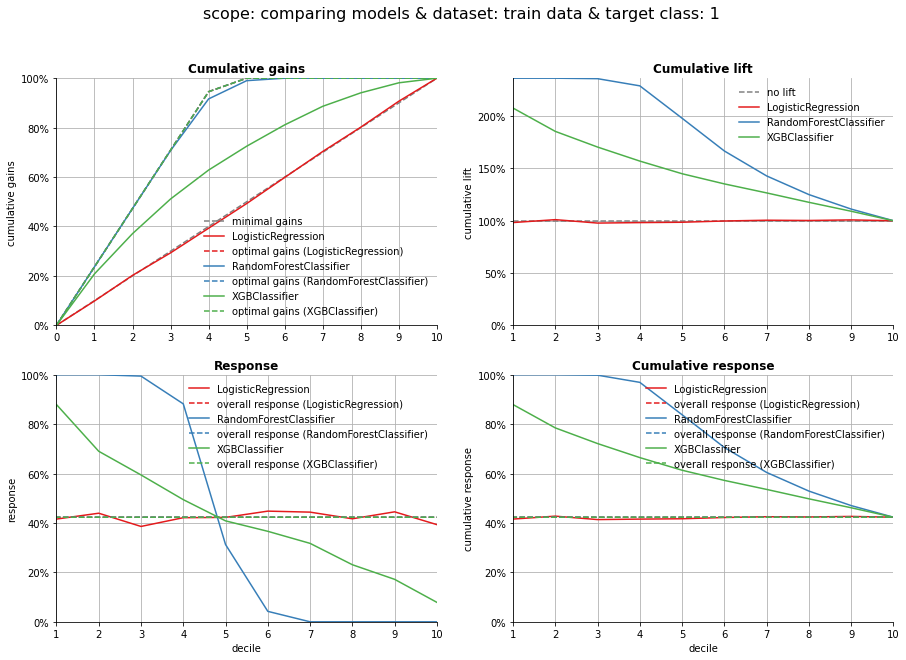

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


compare models
The label with smallest class is [1]


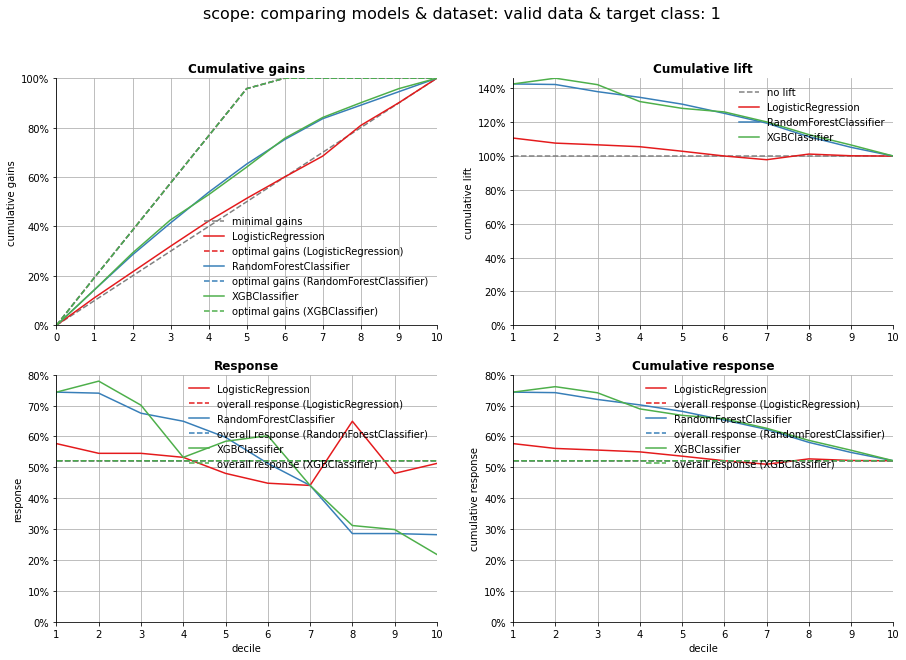

In [58]:
tsc.compare_models()

### Testing

Final model: LogisticRegression(C=0.05129160675560647, fit_intercept=False, max_iter=1000,
                   n_jobs=-1, random_state=0, tol=9.298144931741162e-05)
0    2420
1    1907
Name: y, dtype: int64
Fitting...
Test score for LogisticRegression = 0.8369682711260882
Took 0 seconds to get final predictions


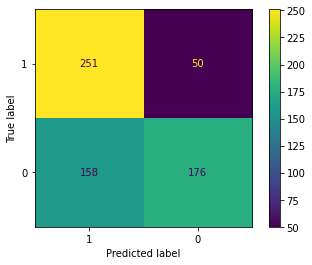

In [59]:
tsc.get_predictions()

### Model explainability

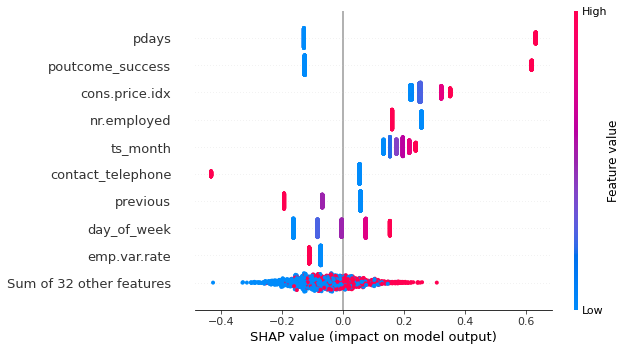

In [65]:
explainer = shap.Explainer(tsc.fitted_final_estimator, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)